In [16]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.image import concat_imgs, mean_img 
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi
from nilearn.image import high_variance_confounds
from nilearn.datasets import load_mni152_brain_mask
from nilearn.image import binarize_img
from nilearn.image import resample_to_img
from nilearn.maskers import NiftiMasker


In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
def CreateEventsDF_and_ContrastKeys(sub_events, events_duration):
    
    # Separate dataframe into run 1 and run 2. 
    sub_run1 = sub_events.iloc[:16, :]
    sub_run2 = sub_events.iloc[16:, :]
    sub_run1.reset_index(drop=True, inplace=True)
    sub_run2.reset_index(drop=True, inplace=True)

    # Create onsets array for each run.
    run1_trailer_onsets = np.array([12, 60, 108, 152, 196, 244, 288, 332, 376, 420, 468, 512, 560, 608, 656, 700])
    run2_trailer_onsets = np.array([12, 60, 108, 152, 200, 244, 288, 332, 380, 428, 476, 520, 568, 616, 660, 704])

    run1_trailer_onsets = run1_trailer_onsets - 8
    run2_trailer_onsets = run2_trailer_onsets - 8

    run1_trailer_labels = np.array(["rh6", "uh1", "rc2", "rh2", "rh1", "rc9", "uc4", "rh9", "uh2", "rc6", "rh3", "rc11", "uc1", "rh11", "rc12", "rc5"])
    run2_trailer_labels = np.array(["rc3", "rh12", "rc1", "rh7", "rc8", "uc3", "rh10", "rc4", "rh4", "uc2", "rh5", "rh8", "rc10", "uh3", "rc7", "uh4"])

    run1_ITI_duration = np.array([6, 6, 6, 2, 2, 6, 2, 2, 2, 2, 6, 2, 6, 6, 6, 2])
    run2_ITI_duration = np.array([2, 6, 6, 2, 6, 2, 2, 2, 6, 6, 6, 2, 6, 6, 2, 2])

    run1_watchQ_onsets = run1_trailer_onsets + 30   
    run2_watchQ_onsets = run2_trailer_onsets + 30

    run1_feelQ_onsets = run1_trailer_onsets + 30 + 4
    run2_feelQ_onsets = run2_trailer_onsets + 30 + 4

    run1_arousalQ_onsets = run1_trailer_onsets + 30 + 4 + 4
    run2_arousalQ_onsets = run2_trailer_onsets + 30 + 4 + 4

    run1_fixation_onsets = run1_trailer_onsets + 30 + 4 + 4 + 4
    run2_fixation_onsets = run2_trailer_onsets + 30 + 4 + 4 + 4

    run1_events_df = pd.DataFrame(columns=["onset", "duration", "trial_type"])
    run2_events_df = pd.DataFrame(columns=["onset", "duration", "trial_type"])

    for trailer_id in range(16):

        # Create a dictionary for each trailer with the onset, duration, and trial type. 
        run1_trailer = {"onset": run1_trailer_onsets[trailer_id], "duration": events_duration, "trial_type": run1_trailer_labels[trailer_id]}
        run2_trailer = {"onset": run2_trailer_onsets[trailer_id], "duration": events_duration, "trial_type": run2_trailer_labels[trailer_id]}

        run1_watchQ = {"onset": run1_watchQ_onsets[trailer_id], "duration": 4, "trial_type": "watchQ"}
        run2_watchQ = {"onset": run2_watchQ_onsets[trailer_id], "duration": 4, "trial_type": "watchQ"}

        run1_feelQ = {"onset": run1_feelQ_onsets[trailer_id], "duration": 4, "trial_type": "feelQ"}
        run2_feelQ = {"onset": run2_feelQ_onsets[trailer_id], "duration": 4, "trial_type": "feelQ"}

        run1_arousalQ = {"onset": run1_arousalQ_onsets[trailer_id], "duration": 4, "trial_type": "arousalQ"}
        run2_arousalQ = {"onset": run2_arousalQ_onsets[trailer_id], "duration": 4, "trial_type": "arousalQ"}

        run1_fixation = {"onset": run1_fixation_onsets[trailer_id], "duration": run1_ITI_duration[trailer_id], "trial_type": "fixation"}
        run2_fixation = {"onset": run2_fixation_onsets[trailer_id], "duration": run2_ITI_duration[trailer_id], "trial_type": "fixation"}

        # Add the dictionary to the dataframe. 
        
        run1_events_df.loc[len(run1_events_df.index)] = run1_trailer 
        run2_events_df.loc[len(run2_events_df.index)] = run2_trailer

        run1_events_df.loc[len(run1_events_df.index)] = run1_watchQ
        run2_events_df.loc[len(run2_events_df.index)] = run2_watchQ

        run1_events_df.loc[len(run1_events_df.index)] = run1_feelQ
        run2_events_df.loc[len(run2_events_df.index)] = run2_feelQ

        run1_events_df.loc[len(run1_events_df.index)] = run1_arousalQ
        run2_events_df.loc[len(run2_events_df.index)] = run2_arousalQ

        run1_events_df.loc[len(run1_events_df.index)] = run1_fixation
        run2_events_df.loc[len(run2_events_df.index)] = run2_fixation

        # run2_events_df = run2_events_df.append(run2_trailer, ignore_index=True)

        # run1_events_df = run1_events_df.append(run1_watchQ, ignore_index=True)
        # run2_events_df = run2_events_df.append(run2_watchQ, ignore_index=True)

        # run1_events_df = run1_events_df.append(run1_feelQ, ignore_index=True)   
        # run2_events_df = run2_events_df.append(run2_feelQ, ignore_index=True)

        # run1_events_df = run1_events_df.append(run1_arousalQ, ignore_index=True)
        # run2_events_df = run2_events_df.append(run2_arousalQ, ignore_index=True)

        # run1_events_df = run1_events_df.append(run1_fixation, ignore_index=True)
        # run2_events_df = run2_events_df.append(run2_fixation, ignore_index=True)

    sub_events = [run1_events_df, run2_events_df]

    return sub_events

In [19]:
# Open a datasets directory. 
fd = os.open("/Users/la/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/la/Documents/Datasets


NAcc is binary mask with unique values:  [0. 1.]
AIns is binary mask with unique values:  [0. 1.]
vmPFC is binary mask with unique values:  [0. 1.]


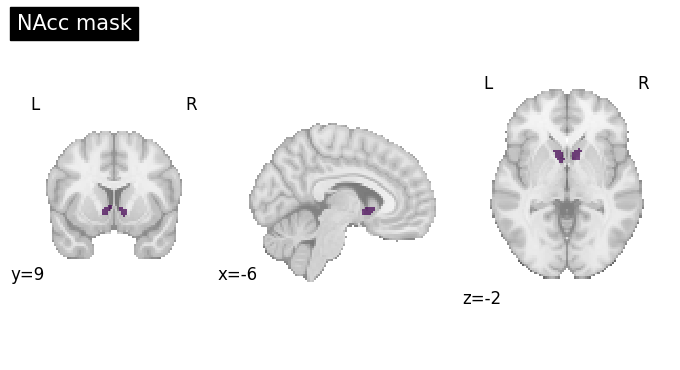

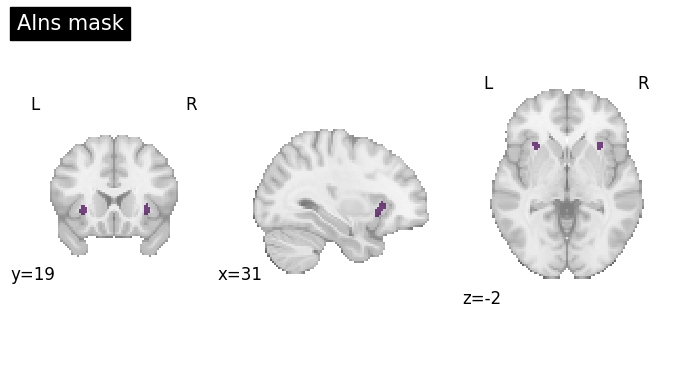

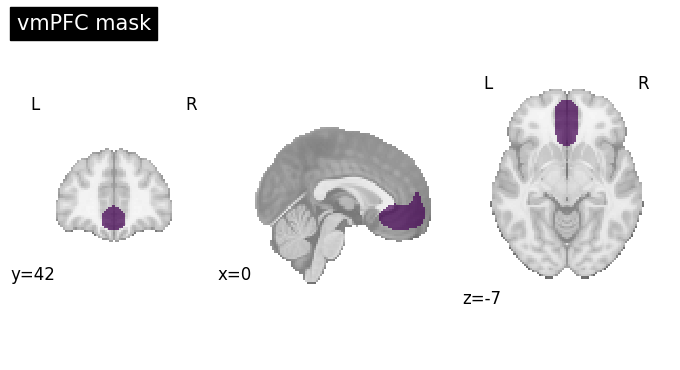

In [20]:
# Load masks from Plassman & Albuquerque study.
NAcc_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/NAc_bilateral.nii"
AIns_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/AI_bilateral.nii"
vmPFC_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/vmPFC_neurosynth_binary_resl.nii"

print("NAcc is binary mask with unique values: ", np.unique(nib.load(NAcc_path).get_fdata()))
print("AIns is binary mask with unique values: ", np.unique(nib.load(AIns_path).get_fdata()))
print("vmPFC is binary mask with unique values: ", np.unique(nib.load(vmPFC_path).get_fdata()))

# Create mask objects.
NAcc_masker = NiftiMasker(mask_img=NAcc_path, standardize=True, verbose=False).fit()
AIns_masker = NiftiMasker(mask_img=AIns_path, standardize=True, verbose=False).fit()
vmPFC_masker = NiftiMasker(mask_img=vmPFC_path, standardize=True, verbose=False).fit()

plot_roi(NAcc_masker.mask_img_, black_bg=False, title="NAcc mask", draw_cross=False, cmap="viridis")
plot_roi(AIns_masker.mask_img_, black_bg=False, title="AIns mask", draw_cross=False, cmap="viridis")
plot_roi(vmPFC_masker.mask_img_, black_bg=False, title="vmPFC mask", draw_cross=False, cmap="viridis")

In [21]:
# Get list of participants.
neural_data_df = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation.csv"
neural_data = pd.read_csv(neural_data_df)
participants_list = neural_data["Participant"].unique().tolist()

all_participants_GLM_df = pd.DataFrame()

for sub_id in participants_list:

    # Load events data for current participant. 
    sub_events_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/" + sub_id + "/" + sub_id + "_processed_events.csv"
    sub_events = pd.read_csv(sub_events_path, sep='\,')

    sub_events = CreateEventsDF_and_ContrastKeys(sub_events, 30) 
    
    # Could use this to get rating activation. 
    #trailers_run1 = sub_events[0]["trial_type"].unique()
    #trailers_run2 = sub_events[1]["trial_type"].unique()

    trailers_run1 = np.array(["rh6", "uh1", "rc2", "rh2", "rh1", "rc9", "uc4", "rh9", "uh2", "rc6", "rh3", "rc11", "uc1", "rh11", "rc12", "rc5"])
    trailers_run2 = np.array(["rc3", "rh12", "rc1", "rh7", "rc8", "uc3", "rh10", "rc4", "rh4", "uc2", "rh5", "rh8", "rc10", "uh3", "rc7", "uh4"])

    # Load fMRI data for current participant.
    sub_run1_func = "MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func = "MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_func_files = [sub_run1_func, sub_run2_func]

    # Load fMRI confounds for current participant.
    sub_run1_confounds = "/Users/la/Documents/Datasets/MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-01_desc-confounds_timeseries.tsv"
    sub_run2_confounds = "/Users/la/Documents/Datasets/MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-02_desc-confounds_timeseries.tsv"

    # Load mask file.
    sub_mask_run1 = "MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    sub_mask_run2 = "MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

    # Binarize sub mask.
    sub_mask_run1_bin = binarize_img(sub_mask_run1)
    sub_mask_run2_bin = binarize_img(sub_mask_run2)

    # Get confounds df for each run.
    sub_run1_confounds = pd.read_csv(sub_run1_confounds, sep='\t')
    sub_run2_confounds = pd.read_csv(sub_run2_confounds, sep='\t')

    simple_confounds = [
                        "rot_x", "rot_y", "rot_z", "trans_x", "trans_y", "trans_z"
                        ]
    
    sub_run1_confounds = sub_run1_confounds[simple_confounds]
    sub_run2_confounds = sub_run2_confounds[simple_confounds]

    # Drop the first 4 TRs from the confounds.
    sub_run1_confounds = sub_run1_confounds.iloc[4:]
    sub_run2_confounds = sub_run2_confounds.iloc[4:]

    sub_run1_confounds = sub_run1_confounds.fillna(0) 
    sub_run2_confounds = sub_run2_confounds.fillna(0)

    sub_confound_files = [sub_run1_confounds, sub_run2_confounds]
    
    # # Get motion confounds. 
    # sub_run1_motion_s_confounds = [i for i in sub_run1_confounds.columns if "state" in i] 
    # sub_run2_motion_s_confounds = [i for i in sub_run2_confounds.columns if "state" in i] 

    # # Select relevant confounds.
    # sub_run1_confounds_simple = sub_run1_confounds[simple_confounds + sub_run1_motion_s_confounds]
    # sub_run2_confounds_simple = sub_run2_confounds[simple_confounds + sub_run2_motion_s_confounds] 

    # # Calculate high variance confounds.
    # sub_run1_hv_confounds = pd.DataFrame(high_variance_confounds(sub_run1_func, percentile=3)) 
    # sub_run2_hv_confounds = pd.DataFrame(high_variance_confounds(sub_run2_func, percentile=3))

    # sub_run1_confounds_df = pd.concat([sub_run1_confounds_simple, sub_run1_hv_confounds], axis=1)
    # sub_run2_confounds_df = pd.concat([sub_run2_confounds_simple, sub_run2_hv_confounds], axis=1)

    # Resample ROI masks to match subject's fMRI data.
    sub_func_data_r1 = nib.load(sub_func_files[0])
    sub_func_data_r2 = nib.load(sub_func_files[1])

    # Drop first 4 TRs.
    sub_run1_func_trim = sub_func_data_r2.slicer[:,:,:,4:]
    sub_run2_func_trim = sub_func_data_r2.slicer[:,:,:,4:]

    NAcc_masker_resampled_r1 = resample_to_img(NAcc_path, sub_func_data_r1, interpolation='nearest')
    AIns_masker_resampled_r1 = resample_to_img(AIns_path, sub_func_data_r1, interpolation='nearest')
    vmPFC_masker_resampled_r1 = resample_to_img(vmPFC_path, sub_func_data_r1, interpolation='nearest')

    NAcc_masker_resampled_r2 = resample_to_img(NAcc_path, sub_func_data_r2, interpolation='nearest')
    AIns_masker_resampled_r2 = resample_to_img(AIns_path, sub_func_data_r2, interpolation='nearest')
    vmPFC_masker_resampled_r2 = resample_to_img(vmPFC_path, sub_func_data_r2, interpolation='nearest')

    NAcc_masker_r1 = NiftiMasker(mask_img=NAcc_masker_resampled_r1, standardize=False, verbose=False).fit()
    AIns_masker_r1 = NiftiMasker(mask_img=AIns_masker_resampled_r1, standardize=False, verbose=False).fit()
    vmPFC_masker_r1 = NiftiMasker(mask_img=vmPFC_masker_resampled_r1, standardize=False, verbose=False).fit()

    NAcc_masker_r2 = NiftiMasker(mask_img=NAcc_masker_resampled_r2, standardize=False, verbose=False).fit()
    AIns_masker_r2 = NiftiMasker(mask_img=AIns_masker_resampled_r2, standardize=False, verbose=False).fit()
    vmPFC_masker_r2 = NiftiMasker(mask_img=vmPFC_masker_resampled_r2, standardize=False, verbose=False).fit()

    # Create first level model.
    glm_run1 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run1_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/128, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')

    glm_run2 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run2_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/128, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')

    # Fit model to data.
    glm_run1.fit(sub_run1_func_trim, 
                       events=sub_events[0], 
                       confounds=sub_confound_files[0])

    glm_run2.fit(sub_run2_func_trim,
                        events=sub_events[1], 
                        confounds=sub_confound_files[1])
    
    # Create dictionary to store results.
    result_dic = {}

    # Loop through each trailer.
    for run_id in range(len(trailers_run1)):

        # Compute contrast for 1st run.
        current_trailer_key_r1 = "+1*" + trailers_run1[run_id] + "-1*fixation" #+ "+1*" + trailers_run1[run_id] + "_derivative"  #+ "-1*fixation_derivative"
        current_trailer_contrast = glm_run1.compute_contrast(current_trailer_key_r1, output_type="effect_size")

        # Get NAcc data.
        NAcc_data_run1 = NAcc_masker_r1.transform(current_trailer_contrast).mean()

        # Get AIns data.
        AIns_data_run1 = AIns_masker_r1.transform(current_trailer_contrast).mean()

        # Get vmPFC data.
        vmPFC_data_run1 = vmPFC_masker_r1.transform(current_trailer_contrast).mean()

        # Compute contrast for 2nd run.
        current_trailer_key_r2 = "+1*" + trailers_run2[run_id] + "-1*fixation" #"+1*" + trailers_run2[run_id] + "_derivative" + "-1*fixation" #+ "-1*fixation_derivative"
        current_trailer_contrast_r2 = glm_run2.compute_contrast(current_trailer_key_r2, output_type="effect_size")

        # Get NAcc data.
        NAcc_data_run2 = NAcc_masker_r2.transform(current_trailer_contrast_r2).mean()

        # Get AIns data.
        AIns_data_run2 = AIns_masker_r2.transform(current_trailer_contrast_r2).mean()

        # Get vmPFC data.
        vmPFC_data_run2 = vmPFC_masker_r2.transform(current_trailer_contrast_r2).mean()

        # Append to dictionary.
        result_dic[trailers_run1[run_id]] = {"NAcc_GLM": NAcc_data_run1, "AIns_GLM": AIns_data_run1, "vmPFC_GLM": vmPFC_data_run1}
        result_dic[trailers_run2[run_id]] = {"NAcc_GLM": NAcc_data_run2, "AIns_GLM": AIns_data_run2, "vmPFC_GLM": vmPFC_data_run2}

    results_df = pd.DataFrame(result_dic).T
    results_df.reset_index(inplace=True)
    results_df.rename(columns={"index": "Trailer"}, inplace=True)

    # Add participant ID to dataframe.
    results_df["Participant"] = sub_id

    # Save results to csv.
    results_df.to_csv("/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/" + sub_id + "/" + sub_id + "_GLM.csv", index=False)

    all_participants_GLM_df = pd.concat([all_participants_GLM_df, results_df], axis=0)
    print("Done with participant: ", sub_id)
    


Done with participant:  sub-01
Done with participant:  sub-02
Done with participant:  sub-03
Done with participant:  sub-04
Done with participant:  sub-08
Done with participant:  sub-09
Done with participant:  sub-10
Done with participant:  sub-11
Done with participant:  sub-12
Done with participant:  sub-13
Done with participant:  sub-14
Done with participant:  sub-15
Done with participant:  sub-17
Done with participant:  sub-18
Done with participant:  sub-19
Done with participant:  sub-21
Done with participant:  sub-22
Done with participant:  sub-23
Done with participant:  sub-25
Done with participant:  sub-26
Done with participant:  sub-27
Done with participant:  sub-28
Done with participant:  sub-29
Done with participant:  sub-30
Done with participant:  sub-31
Done with participant:  sub-32
Done with participant:  sub-33
Done with participant:  sub-34
Done with participant:  sub-35
Done with participant:  sub-36
Done with participant:  sub-37


In [22]:
# Save data to csv.
all_participants_GLM_df.to_csv("/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation_GLM.csv", index=False)
all_participants_GLM_df.head()

,Trailer,NAcc_GLM,AIns_GLM,vmPFC_GLM,Participant
0,rh6,-0.075064,-0.038343,0.128898,sub-01
1,rc3,0.008662,0.104496,0.260155,sub-01
2,uh1,0.374937,-0.057582,0.202162,sub-01
3,rh12,0.028335,0.126764,0.093376,sub-01
4,rc2,0.301736,0.345088,0.737234,sub-01


In [23]:
# Create onsets array for each run.
run1_trailer_onsets = np.array([12, 60, 108, 156, 200, 244, 292, 336, 380, 424, 468, 516, 560, 608, 656, 704])   
run2_trailer_onsets = np.array([12, 56, 104, 152, 196, 244, 288, 332, 376, 424, 472, 520, 564, 612, 660, 704])

run1_watchQ_onsets = run1_trailer_onsets + 30   
run2_watchQ_onsets = run2_trailer_onsets + 30

run1_feelQ_onsets = run1_trailer_onsets + 30 + 4
run2_feelQ_onsets = run2_trailer_onsets + 30 + 4

run1_arousalQ_onsets = run1_trailer_onsets + 30 + 4 + 4
run2_arousalQ_onsets = run2_trailer_onsets + 30 + 4 + 4

run1_fixation_onsets = run1_trailer_onsets + 30 + 4 + 4 + 4
run2_fixation_onsets = run2_trailer_onsets + 30 + 4 + 4 + 4





In [24]:
all_participants_GLM_df.head()

,Trailer,NAcc_GLM,AIns_GLM,vmPFC_GLM,Participant
0,rh6,-0.075064,-0.038343,0.128898,sub-01
1,rc3,0.008662,0.104496,0.260155,sub-01
2,uh1,0.374937,-0.057582,0.202162,sub-01
3,rh12,0.028335,0.126764,0.093376,sub-01
4,rc2,0.301736,0.345088,0.737234,sub-01
